In [1]:
import os
import sys
from collections import defaultdict
from functools import partial
import itertools
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from pandas.errors import SettingWithCopyWarning
import numpy as np
from matplotlib_inline.backend_inline import set_matplotlib_formats
set_matplotlib_formats('retina', 'png')

from tqdm.notebook import tqdm 
from math import factorial, log, log10, log1p, floor, ceil
from scipy.stats import chi2

import multiprocess

sns.set()
sns.set_style("ticks")

import tskit
import msprime

import geneinfo as gi
gi.email('kaspermunch@birc.au.dk')

# scale down size of default plots
sns.set_context("paper")
import matplotlib as mpl
scale = 0.8
d = dict([(k, v*scale) for (k, v) in sns.plotting_context('paper').items()])
d['figure.figsize'] = [5.4, 3.5]
mpl.rcParams.update(d)

def modpath(p, parent=None, base=None, suffix=None):
    par, name = os.path.split(p)
    name_no_suffix, suf = os.path.splitext(name)
    if type(suffix) is str:
        suf = suffix
    if parent is not None:
        par = parent
    if base is not None:
        name_no_suffix = base
    new_path = os.path.join(par, name_no_suffix + suf)
    if type(suffix) is tuple:
        assert len(suffix) == 2
        new_path, nsubs = re.subn(r'{}$'.format(suffix[0]), suffix[1], new_path)
        assert nsubs == 1, nsubs
    return new_path

In [3]:
from scipy.stats import chi2
def fisher_method(pvalues):
    df = 2* len(pvalues)
    return 1-chi2.cdf(-2*sum(map(log, pvalues)), df)
    
p = fisher_method([1e-4, 1e-3])
-np.log10(p)

5.766544551240487

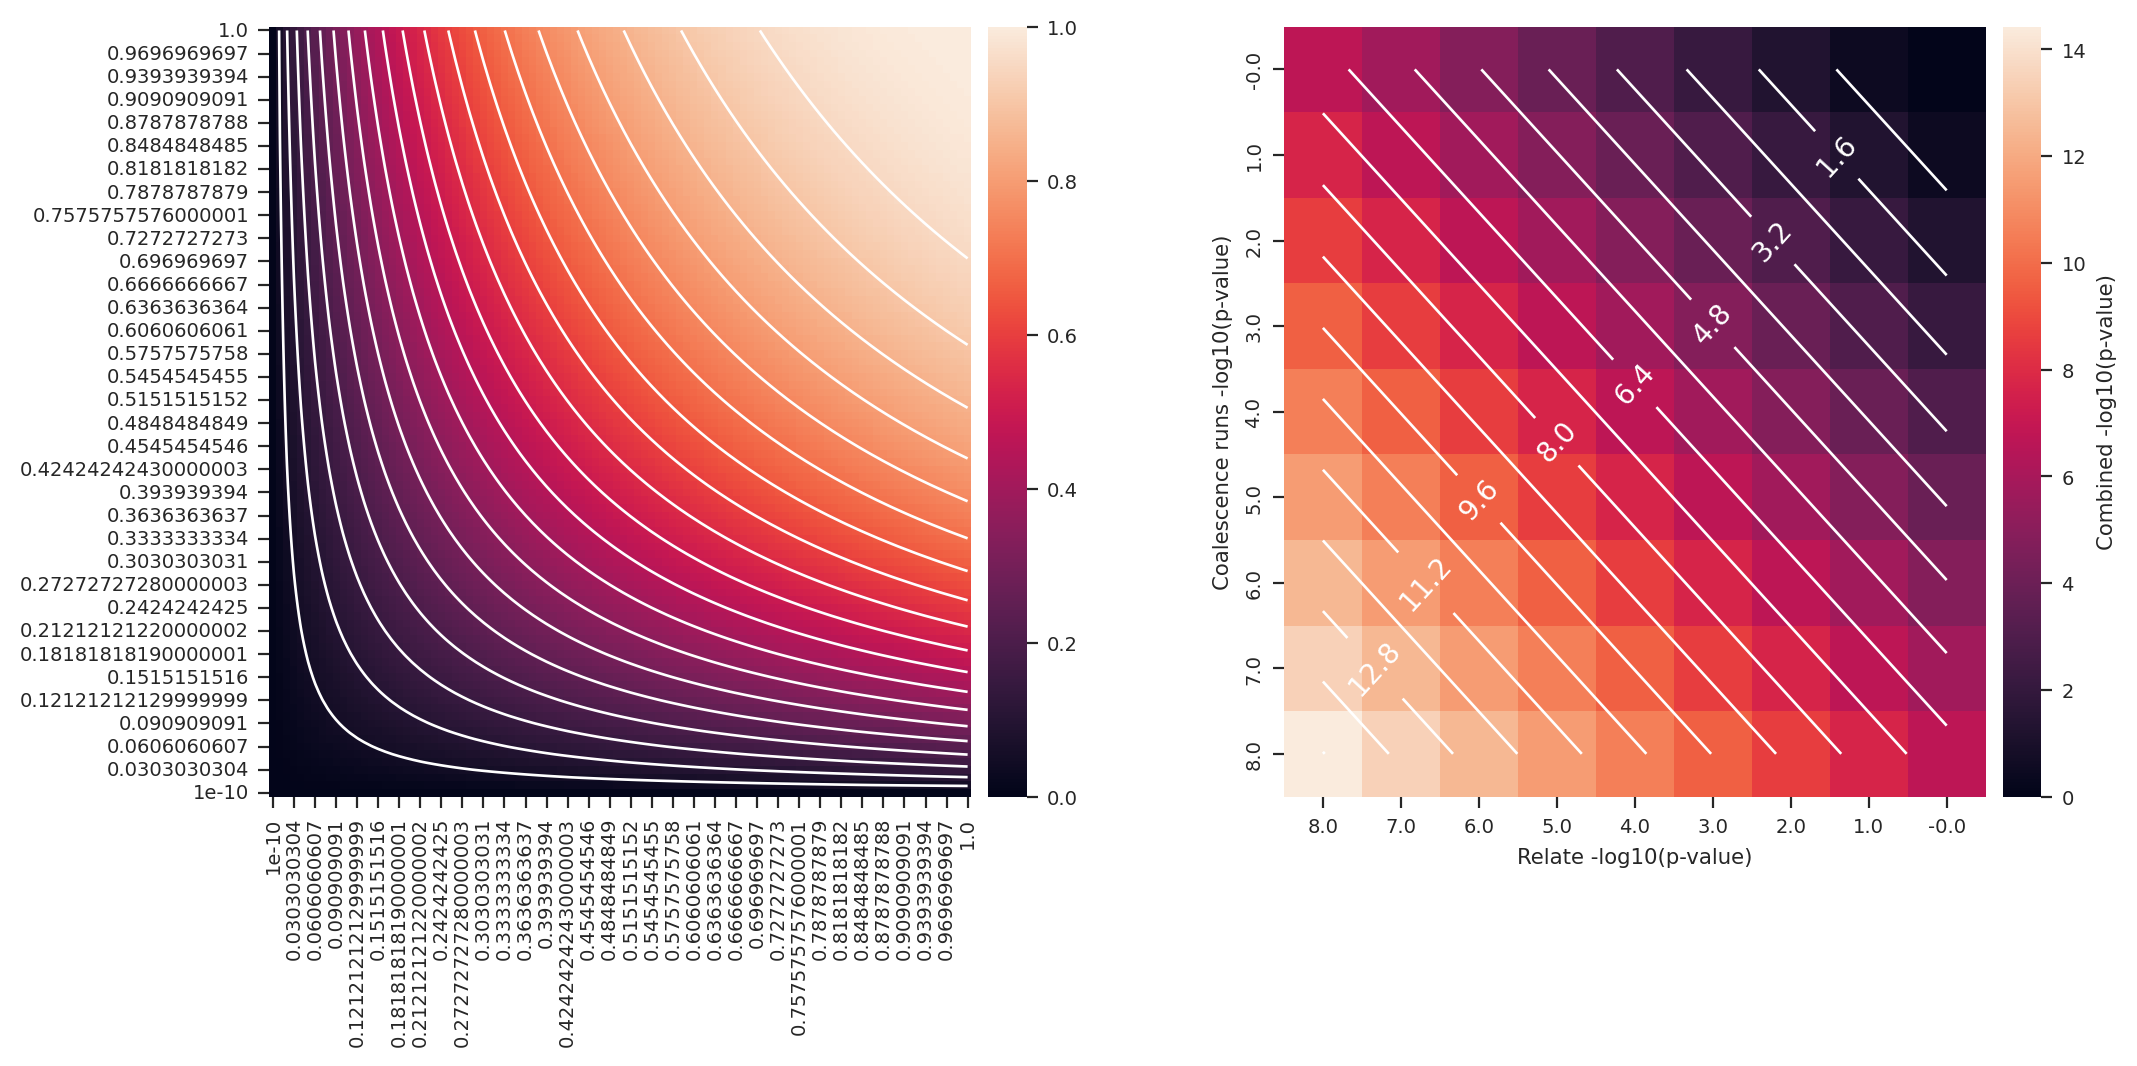

In [3]:
def fisher_method(pvalues):
    df = 2* len(pvalues)
    return 1-chi2.cdf(-2*sum(map(log, pvalues)), df)
    
n = 100
x = np.linspace(1e-10, 1, n)
a = np.array(list(itertools.product(x, x)))
b = np.apply_along_axis(fisher_method, 1, a)
c = b.reshape(n, n)
data = pd.DataFrame(c)
data.index = x
data.columns = x

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))
sns.heatmap(data=data, cbar_kws={'pad': 0.02}, ax=ax1)
ax1.contour(np.arange(.5, data.shape[1]), np.arange(.5, data.shape[0]), data, levels=20, colors='white')
ax1.invert_yaxis()



def fisher_method_log10(pvalues):
    df = 2* len(pvalues)
    return -np.log10(1-chi2.cdf(-2*sum(map(log, pvalues)), df))
    # return 1-chi2.cdf(-2*sum(map(log, pvalues)), df)

pmin = -8
n = -pmin*1+1
# x = np.logspace(1e-10, 1, n)
x = np.logspace(-8, 0, n)
a = np.array(list(itertools.product(x, x)))
b = np.apply_along_axis(fisher_method_log10, 1, a)
c = b.reshape(n, n)
data = pd.DataFrame(c)
data.index = np.round(-np.log10(x), 1)
data.columns = np.round(-np.log10(x), 1)

sns.heatmap(data=data, cbar_kws={'pad': 0.02, 'label': 'Combined -log10(p-value)'}, ax=ax2)
cs = ax2.contour(np.arange(.5, data.shape[1]), np.arange(.5, data.shape[0]), data, levels=20, colors='white')

def fmt(x):
    return np.round(x,2)

ax2.clabel(cs, cs.levels[::2], inline=True, fmt=fmt, fontsize=10)
ax2.invert_yaxis()
plt.xlabel('Relate -log10(p-value)')
plt.ylabel('Coalescence runs -log10(p-value)') ;

In [3]:
import scipy

class Comb():

    cache = {}
    
    def __init__(self):
        pass

    def __call__(self, n, k, exact=True):
        if (n, k) not in self.cache:
            self.cache[(n, k)] = scipy.special.comb(n, k, exact=exact)
        return self.cache[(n, k)]

    @classmethod
    def clear(cls):
        cls.cache = {}

    def __enter__(self):

        def init_worker(data):
            # declare scope of a new global variable
            global comb
            # store argument in the global variable for this process
            comb = data
            
        self.pool = multiprocess.Pool(processes=8, initializer=init_worker, initargs=(self,))
        return self.pool

    def __exit__(self, type, value, tb):
        self.pool.close()

Comb().clear()
comb = Comb()

with Comb() as pool:
    pass

In [4]:
## Combinatorial results and functions for run probabilities ##
def get_coalescence_runs(all_times, clade_times):
    clade_times_set = set(clade_times)
    k, fn = 1, 1
    coalescence_runs = []
    first_derived_coal_found = False
    for t in all_times:
        is_derived = int( t in clade_times_set)
        if first_derived_coal_found:
            coalescence_runs.append(is_derived)
        if is_derived:
            # get all the coalescences *after* the first derived one. So that the first can be both 0 and 1
            first_derived_coal_found = True
    return np.array(coalescence_runs)

def get_runs_of_1s(bits):
    for bit, group in itertools.groupby(bits):
        if bit:
            yield sum(group)

def get_all_runs(bits):
    for bit, group in itertools.groupby(bits):
        if bit:
            yield sum(group)
    bits = np.absolute(bits - 1)
    for bit, group in itertools.groupby(bits):
        if bit:
            yield sum(group)

In [5]:
def prob_nr_of_runs(n, n1, n2):
    """
    Probability of the number runs of either zeros or ones
    n: number of runs
    n0: nr zeros
    n1: nr ones
    """
    if n % 2:
        # uneven
        k = (n - 1) //  2
        return (comb(n1-1, k)*comb(n2-1, k-1) + comb(n1-1, k-1)*comb(n2-1, k)) / comb(n1+n2, n1)
    else:
        # even
        k = n // 2
        return 2*comb(n1-1, k-1)*comb(n2-1, k-1) / comb(n1+n2, n1)    

In [7]:
## Compute cached probabilities ##

%%time
import multiprocess
pool = multiprocess.Pool(processes=8)

n = 200
dim = 2*n+1
cache = np.ndarray(shape=(n+1, n+1, 2*n+1), dtype=float)
cache[:, :, :] = np.nan
for n0 in tqdm(range(1, n+1)):
    for n1 in range(1, n+1):
        for r in range(1, n0+n1):
            cache[n0, n1, r] = prob_nr_of_runs(r, n0, n1)

pool.close()

np.save('prob_nr_of_runs_cache.npy', cache)

UsageError: Line magic function `%%time` not found.


In [8]:
## Compute p-values for data ##
prob_nr_of_runs_cache = np.load('prob_nr_of_runs_cache.npy')

def extract_population_name(file_path):
    # Split the file path by '/'
    parts = file_path.split('/')
    # Extract the second to last part which contains the population name
    return parts[-4]

for treeseq_file_name in [
    # africans
    '/home/ari/ari-intern/people/ari/ariadna-intern/steps/LWK/relate/run_relate/1000g_ppl_phased_haplotypes.trees',
    '/home/ari/ari-intern/people/ari/ariadna-intern/steps/GWD/relate/run_relate/1000g_ppl_phased_haplotypes.trees',
    '/home/ari/ari-intern/people/ari/ariadna-intern/steps/ESN/relate/run_relate/1000g_ppl_phased_haplotypes.trees',
    '/home/ari/ari-intern/people/ari/ariadna-intern/steps/MSL/relate/run_relate/1000g_ppl_phased_haplotypes.trees',
    '/home/ari/ari-intern/people/ari/ariadna-intern/steps/YRI/relate/run_relate/1000g_ppl_phased_haplotypes.trees',
    # europeans
    '/home/ari/ari-intern/people/ari/ariadna-intern/steps/GBR/relate/run_relate/1000g_ppl_phased_haplotypes.trees',
    '/home/ari/ari-intern/people/ari/ariadna-intern/steps/FIN/relate/run_relate/1000g_ppl_phased_haplotypes.trees',
    '/home/ari/ari-intern/people/ari/ariadna-intern/steps/IBS/relate/run_relate/1000g_ppl_phased_haplotypes.trees',
    '/home/ari/ari-intern/people/ari/ariadna-intern/steps/TSI/relate/run_relate/1000g_ppl_phased_haplotypes.trees',
    # asians
    '/home/ari/ari-intern/people/ari/ariadna-intern/steps/CDX/relate/run_relate/1000g_ppl_phased_haplotypes.trees',
    '/home/ari/ari-intern/people/ari/ariadna-intern/steps/CHB/relate/run_relate/1000g_ppl_phased_haplotypes.trees',
    '/home/ari/ari-intern/people/ari/ariadna-intern/steps/CHS/relate/run_relate/1000g_ppl_phased_haplotypes.trees',
    '/home/ari/ari-intern/people/ari/ariadna-intern/steps/JPT/relate/run_relate/1000g_ppl_phased_haplotypes.trees',
    '/home/ari/ari-intern/people/ari/ariadna-intern/steps/KHV/relate/run_relate/1000g_ppl_phased_haplotypes.trees'
                         ]:
    print(os.path.basename(treeseq_file_name))
    
    population_name = extract_population_name(treeseq_file_name)
    
    output_file_name = modpath(treeseq_file_name, parent='/home/ari/ari-intern/people/ari/ariadna-intern/results/', suffix=f'_{population_name}_runstats.h5')
    
    tree_seq = tskit.load(treeseq_file_name)
    
    
    nr_samples = tree_seq.num_samples
    
    records = []
    nodes_time = tree_seq.nodes_time

    tree_idx = 0
    for tree in tqdm(tree_seq.trees()):
    
        N = tree.num_samples()
        all_times = [nodes_time[n] for n in tree.timedesc() if not tree.is_leaf(n)]
        for mut in tree.mutations():
            node = tree_seq.mutations_node[mut.id]
            clade_times = [nodes_time[n] for n in tree.timedesc(node) if not tree.is_leaf(n)]

            # nr-all-runs and max ones-run probabilities
            runs = get_coalescence_runs(all_times, clade_times)

            if len(runs) < nr_samples / 4:
                continue
            
            n1 = sum(runs)
            n0 = len(runs) - n1
            run_lengths = np.fromiter(get_all_runs(runs), int)
            runs_of_1s = list(get_runs_of_1s(runs))

            if len(runs_of_1s) == 0:
                # trippleton or smaller
                continue

            max_ones_run_len = max(runs_of_1s)
            nr_runs = run_lengths.size

            
            if nr_runs == 1 or len(runs) <= 2 or nr_runs == len(runs):
                pvalue_nr_runs = np.nan
            else:
                try:
                    pvalue_nr_runs = prob_nr_of_runs_cache[n0, n1, 1:(nr_runs+1)].sum()
                except IndexError:
                    pvalue_nr_runs = sum(prob_nr_of_runs(x, n0, n1) for x in range(1, nr_runs+1))
            
            interval = tree.interval
            num_mutations = tree.num_mutations

            clade_left, clade_right = interval.left, interval.right

            assert clade_times
            
            records.append(['nr_runs',
                            mut.site, 
                            pvalue_nr_runs,
                            nr_runs,
                            len(runs),                            
                            clade_times[0], 
                            0,
                            interval.left,
                            interval.right,
                            clade_left, 
                            clade_right,
                            num_mutations])
    
    
        tree_idx += 1
    
    
    df = pd.DataFrame.from_records(records, columns=['stat_name', 'site', 'p', 'stat', 'nr_coal', 't1', 't2', 
                                                     'tree_left', 'tree_right', 'clade_left', 'clade_right', 
                                                     'nr_mut'])
    df['pos'] = tree_seq.sites_position[df.site]
    df.to_hdf(output_file_name, 'df', format='table')

1000g_ppl_phased_haplotypes.trees


  0%|          | 0/41582 [00:00<?, ?it/s]

1000g_ppl_phased_haplotypes.trees


  0%|          | 0/40565 [00:00<?, ?it/s]


KeyboardInterrupt



In [ ]:
# africans
LWK = pd.read_hdf('/home/ari/ari-intern/people/ari/ariadna-intern/results/1000g_ppl_phased_haplotypes_LWK_runstats.h5')
GWD = pd.read_hdf('/home/ari/ari-intern/people/ari/ariadna-intern/results/1000g_ppl_phased_haplotypes_GWD_runstats.h5')
ESN = pd.read_hdf('/home/ari/ari-intern/people/ari/ariadna-intern/results/1000g_ppl_phased_haplotypes_ESN_runstats.h5')
MSL = pd.read_hdf('/home/ari/ari-intern/people/ari/ariadna-intern/results/1000g_ppl_phased_haplotypes_MSL_runstats.h5')
YRI = pd.read_hdf('/home/ari/ari-intern/people/ari/ariadna-intern/results/1000g_ppl_phased_haplotypes_YRI_runstats.h5')

# europeans
GBR = pd.read_hdf('/home/ari/ari-intern/people/ari/ariadna-intern/results/1000g_ppl_phased_haplotypes_GBR_runstats.h5')
FIN = pd.read_hdf('/home/ari/ari-intern/people/ari/ariadna-intern/results/1000g_ppl_phased_haplotypes_FIN_runstats.h5')
IBS = pd.read_hdf('/home/ari/ari-intern/people/ari/ariadna-intern/results/1000g_ppl_phased_haplotypes_IBS_runstats.h5')
TSI = pd.read_hdf('/home/ari/ari-intern/people/ari/ariadna-intern/results/1000g_ppl_phased_haplotypes_TSI_runstats.h5')


# asians 
CDX = pd.read_hdf('/home/ari/ari-intern/people/ari/ariadna-intern/results/1000g_ppl_phased_haplotypes_CDX_runstats.h5')
CHB = pd.read_hdf('/home/ari/ari-intern/people/ari/ariadna-intern/results/1000g_ppl_phased_haplotypes_CHB_runstats.h5')
CHS = pd.read_hdf('/home/ari/ari-intern/people/ari/ariadna-intern/results/1000g_ppl_phased_haplotypes_CHS_runstats.h5')
JPT = pd.read_hdf('/home/ari/ari-intern/people/ari/ariadna-intern/results/1000g_ppl_phased_haplotypes_JPT_runstats.h5')
KHV = pd.read_hdf('/home/ari/ari-intern/people/ari/ariadna-intern/results/1000g_ppl_phased_haplotypes_KHV_runstats.h5')

In [3]:
LWK = pd.read_hdf('/home/ari/ari-intern/people/ari/ariadna-intern/results/1000g_ppl_phased_haplotypes_LWK_runstats.h5')
print(LWK)

      stat_name    site         p  stat  nr_coal            t1  t2  \
0       nr_runs       3  1.000000     3       81    307.649048   0   
1       nr_runs       4  0.552704    19      122   1131.935791   0   
2       nr_runs       5  0.973672    81      146   4033.751221   0   
3       nr_runs      11  0.357742    67      150   8016.371094   0   
4       nr_runs      18  1.000000     3       50    133.772415   0   
...         ...     ...       ...   ...      ...           ...  ..   
83268   nr_runs  122570  1.000000    21      130   1537.286133   0   
83269   nr_runs  122571  0.332428    12      110    748.525757   0   
83270   nr_runs  122572  0.855525    41      151  34677.253906   0   
83271   nr_runs  122575  0.574144    21      140   3747.725342   0   
83272   nr_runs  122576  0.574144    21      140   3747.725342   0   

        tree_left  tree_right  clade_left  clade_right  nr_mut         pos  
0       2781609.5   2781896.0   2781609.5    2781896.0       2   2781642.0  
1    

In [4]:
LWK_R = pd.read_hdf('/home/ari/ari-intern/people/ari/ariadna-intern/steps/LWK/relate/run_relate/1000g_ppl_phased_haplotypes_selection.sele')
print(LWK_R)

HDF5ExtError: HDF5 error back trace

  File "H5F.c", line 620, in H5Fopen
    unable to open file
  File "H5VLcallback.c", line 3501, in H5VL_file_open
    failed to iterate over available VOL connector plugins
  File "H5PLpath.c", line 578, in H5PL__path_table_iterate
    can't iterate over plugins in plugin path '(null)'
  File "H5PLpath.c", line 620, in H5PL__path_table_iterate_process_path
    can't open directory: /home/ari/miniconda3/envs/arifdp/lib/hdf5/plugin
  File "H5VLcallback.c", line 3351, in H5VL__file_open
    open failed
  File "H5VLnative_file.c", line 97, in H5VL__native_file_open
    unable to open file
  File "H5Fint.c", line 1990, in H5F_open
    unable to read superblock
  File "H5Fsuper.c", line 405, in H5F__super_read
    file signature not found

End of HDF5 error back trace

Unable to open/create file '/home/ari/ari-intern/people/ari/ariadna-intern/steps/LWK/relate/run_relate/1000g_ppl_phased_haplotypes_selection.sele'

In [ ]:
plt.hist(LWK.nr_mut)

In [ ]:
plt.hist(GWD.nr_mut)

In [ ]:
plt.hist(ESN.nr_mut)

In [ ]:
plt.hist(MSL.nr_mut)

In [ ]:
plt.hist(YRI.nr_mut)

In [ ]:
plt.hist(GBR.nr_mut)

In [ ]:
plt.hist(FIN.nr_mut)

In [ ]:
plt.hist(IBS.nr_mut)

In [ ]:
plt.hist(TSI.nr_mut)

In [ ]:
plt.hist(CDX.nr_mut)

In [ ]:
plt.hist(CHB.nr_mut)

In [ ]:
plt.hist(CHS.nr_mut)

In [ ]:
plt.hist(JPT.nr_mut)

In [ ]:
plt.hist(KHV.nr_mut)

In [ ]:
## MANHATTAN PLOTS ##

/scratch/37891617/ipykernel_3196267/2944297291.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  plot_LWK['-log10p'] = -np.log10(plot_LWK.p)


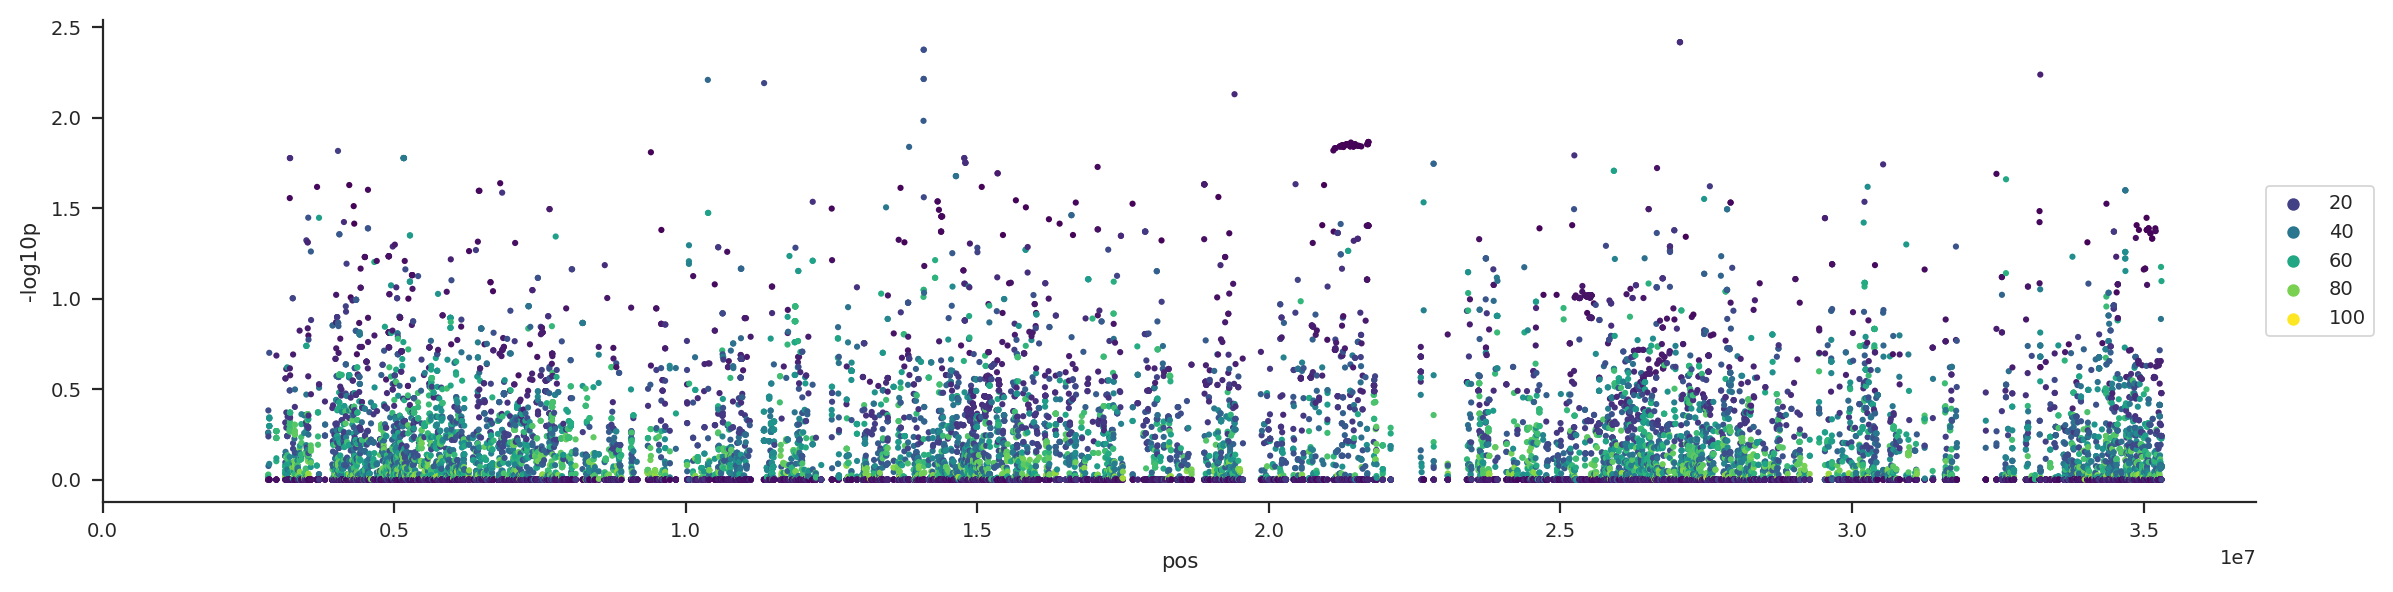

In [5]:
# LWK
plot_LWK = LWK.loc[(LWK.stat_name == 'nr_runs') & (LWK.nr_mut > 20)]
plot_LWK['-log10p'] = -np.log10(plot_LWK.p)
np.log10(plot_LWK.index.size)

import warnings
with warnings.catch_warnings():
    warnings.simplefilter(action='ignore', category=FutureWarning)
    fig, ax = plt.subplots(1, 1, figsize=(12,3))
    sns.scatterplot(data=plot_LWK, x='pos', y='-log10p', hue='stat', palette='viridis', ax=ax, linewidth=0, s=5) ;
    ax.set_xticks(np.arange(0, max(LWK.pos)+1, 5000000))
    # ax.axhline(-np.log10(0.001), color='red', linestyle='dashed') ;
    # ax.get_legend().remove()
    ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    plt.tight_layout()
    sns.despine()

In [ ]:
# GWD
plot_GWD = GWD.loc[(GWD.stat_name == 'nr_runs') & (GWD.nr_mut > 20)]
plot_GWD['-log10p'] = -np.log10(plot_GWD.p)
np.log10(plot_GWD.index.size)

import warnings
with warnings.catch_warnings():
    warnings.simplefilter(action='ignore', category=FutureWarning)
    fig, ax = plt.subplots(1, 1, figsize=(12,3))
    sns.scatterplot(data=plot_GWD, x='pos', y='-log10p', hue='stat', palette='viridis', ax=ax, linewidth=0, s=5) ;
    ax.set_xticks(np.arange(0, max(GWD.pos)+1, 5000000))
    # ax.axhline(-np.log10(0.001), color='red', linestyle='dashed') ;
    # ax.get_legend().remove()
    ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    plt.tight_layout()
    sns.despine()